In [21]:
import sys
# change accordingly
sys.path.append('/Users/monazehni/repos/2D-point-source-localization/python/')
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt

from point_gen import PointGen2D
from feature_gen import FeatureGen2D
from utils_python import plot_feature_baseline, gen_prony_mat, plot_roots

## Setting the parameters:

In [30]:
def arg_parse():
    """
    Parses the passed arguments

    :return: the parsed arguments
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('-numPoint', type=int, default=3, help='the number of points')
    parser.add_argument('-numProj', type=int, default=5000, help='the number of projection lines')
    parser.add_argument('-distType', type=str, default='pairwise', help='the distance use to constrain the generation of the point source model')
    parser.add_argument('-constrained', action='store_true', default=False, help='to apply the minimum separation constraint to generation of the point sources or not')
    parser.add_argument('-minDist', type=float, default=0.1, help='the minimum distance')
    parser.add_argument('-L', type=int, default=1000, help='the number of discretizations of the projection lines')
    parser.add_argument('-R', type=float, default=1., help='the maximum distance of the points from the center')
    parser.add_argument('-sigmaG', type=float, default=0.005, help='the std of the Gaussians used to generate the point sources')
    parser.add_argument('-snr', type=float, default=1000, help='the signal to noise ratio')
    parser.add_argument('-seed', type=int, default=1, help='the random seed')
    args = parser.parse_args(args=[])
    return args

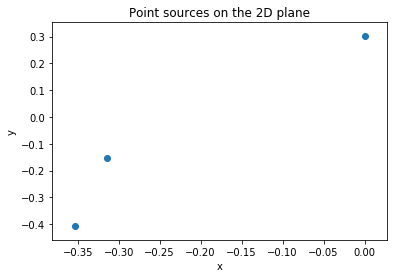

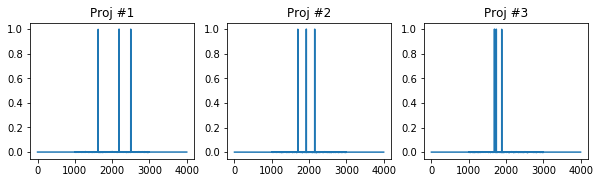

[0.30233259 0.53941563 0.3496915 ]


In [31]:
# generating the point-source model
args = arg_parse()
args.constrained = True
np.random.seed(args.seed)
fcutoff = np.round(2 * args.L)
points = PointGen2D(args)
supp = 3 * np.max(points.radialDist)
pixelSize = supp / (2 * args.L + 1)
proj, nVar = points.proj_1d_point(pixelSize, args.snr)

# plotting the point source model and examples of the projections
plt.figure()
plt.scatter(points.X, points.Y)
plt.xlabel('x',fontsize=10); plt.ylabel('y',fontsize=10); plt.title('Point sources on the 2D plane')

plt.figure(figsize=(10, 2.5))
plt.subplot(131); plt.plot(proj[:,10]); plt.title('Proj #1')
plt.subplot(132); plt.plot(proj[:,500]); plt.title('Proj #2')
plt.subplot(133); plt.plot(proj[:,1000]); plt.title('Proj #3')
plt.show()
print(points.radialDist)

In [32]:
# generate the features
feature = FeatureGen2D(proj, args.numPoint, fcutoff, pixelSize)
# mean feature
uMax = 1.1 * np.max(points.radialDist)
muSample, muSampleDist, uMean = feature.mean_sample(uMax)
# auto-correlation features
uMax = 1.1 * np.max(points.pairDist)
corrSample, corrSampleDist, uCorr = feature.corr_sample(nVar, uMax)

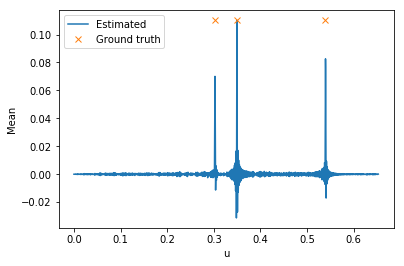

<Figure size 432x288 with 0 Axes>

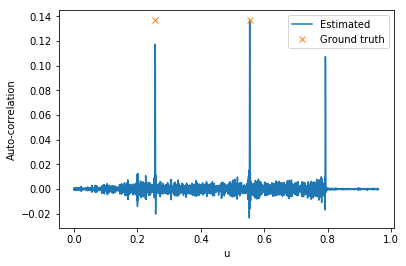

[0.25628507 0.5542066  0.79306599]


<Figure size 432x288 with 0 Axes>

In [33]:
# plotting the features
plot_feature_baseline(muSampleDist, uMean, points.radialDist, feature='Mean')
plot_feature_baseline(corrSampleDist, uCorr, points.pairDist, feature='Auto-correlation')
print(points.pairDist)

## Extract radial distances

In [34]:
start_r = 10
M_prony = args.numPoint * 10;
r_interval = np.arange(start_r-1, start_r+M_prony)
b_pairwise = muSample[r_interval];
                
M = proj.shape[0] 
prony_mat, prony_vec = gen_prony_mat(b_pairwise*np.sqrt(r_interval), args.numPoint * 2);
c = np.dot(np.linalg.pinv(prony_mat), prony_vec)
c = np.concatenate((np.ones((1, 1)), c), axis=0)
r_radial = np.roots(c.squeeze());
                
# extract the geometry information from the roots
tmp = np.angle(r_radial);
# choosing the points that are in the first half of the circle
ind1 = (tmp<=math.pi);
ind2 = (tmp>=0);
index = ind1 & ind2;
                
# choosing the K roots that are closest to the unit circle
r_radial = r_radial[index]
I = np.argsort(np.absolute(1-np.absolute(r_radial)))
r_radial = r_radial[I[0:args.numPoint]]
r_rec = (np.angle(r_radial) * pixelSize * M) / (2 * math.pi)
                   
# error between the recovered and true radial distances
error = np.linalg.norm(np.sort(r_rec)-np.sort(points.radialDist))

The error between the recovered and ground truth radial distances: 0.001597


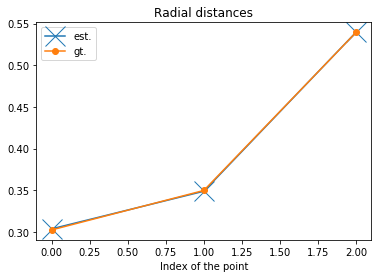

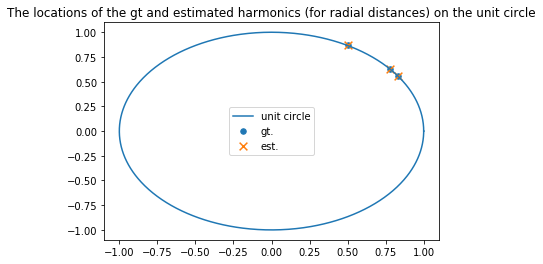

In [35]:
# results:
print('The error between the recovered and ground truth radial distances: %f' %error)
plt.figure()
plt.plot(np.sort(r_rec), label='est.', marker='x', markersize=20)
plt.plot(np.sort(points.radialDist), label='gt.', marker='o')
plt.legend()
plt.title('Radial distances')
plt.xlabel('Index of the point')
# plotting the roots
plot_roots(r_radial, points.radialDist, pixelSize, M, 'radial')

## Extract pairwise distances

In [36]:
# apply the same thing for the pairwise distances
start_r = 10
M_prony = args.numPoint * 30;
r_interval = np.arange(start_r, start_r+M_prony)
b_pairwise = corrSample[r_interval];
                
M = proj.shape[0]
prony_mat, prony_vec = gen_prony_mat((b_pairwise/2.)*np.sqrt(r_interval), args.numPoint * (args.numPoint-1));
c = np.dot(np.linalg.pinv(prony_mat), prony_vec)
c = np.concatenate((np.ones((1, 1)), c), axis=0)
r_pair = np.roots(c.squeeze());
                
# extract the geometry information from the roots
tmp = np.angle(r_pair);
# choosing the points that are in the first half of the circle
ind1 = (tmp<=math.pi);
ind2 = (tmp>=0);
index = ind1 & ind2;
                
# choosing the (args.numPoint*(args.numPoint-1))//2 roots that are closest to the unit circle
r_pair = r_pair[index]
I = np.argsort(np.absolute(1-np.absolute(r_pair)))
r_pair = r_pair[I[0:(args.numPoint*(args.numPoint-1))//2]]
r_rec = (np.angle(r_pair) * pixelSize * M) / (2 * math.pi)
                   
# error between the recovered and true radial distances
error = np.linalg.norm(np.sort(r_rec)-np.sort(points.pairDist))

The error between the recovered and ground truth pairwise distances: 0.000103


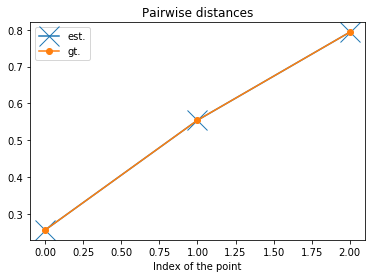

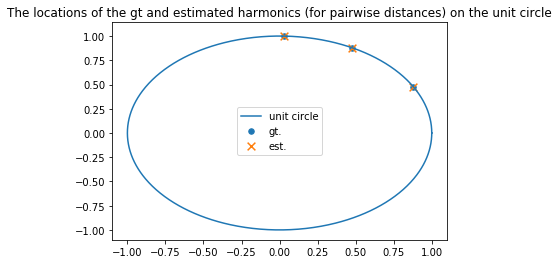

In [38]:
# results
print('The error between the recovered and ground truth pairwise distances: %f' %error)
plt.figure()
plt.plot(np.sort(r_rec), label='est.', marker='x', markersize=20)
plt.plot(np.sort(points.pairDist), label='gt.', marker='o')
plt.legend()
plt.title('Pairwise distances')
plt.xlabel('Index of the point')

plot_roots(r_pair, points.pairDist, pixelSize, M, 'pairwise')